In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## 1. Importing the necessary libraries

In [ ]:
from os import listdir
from glob import glob
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#plotly
!pip install chart_studio
import plotly.express as px
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

import seaborn as sns
sns.set(style="whitegrid")


#pydicom
import pydicom

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')


# Settings for pretty nice plots
plt.style.use('fivethirtyeight')
plt.show()


## 2. Reading the datasets

In [ ]:
# Defining data path
IMAGE_PATH = "/kaggle/input/osic-pulmonary-fibrosis-progression/"

data_path = '/kaggle/input/osic-pulmonary-fibrosis-progression/train/'

train_df = pd.read_csv('/kaggle/input/osic-pulmonary-fibrosis-progression/train.csv')
test_df = pd.read_csv('/kaggle/input/osic-pulmonary-fibrosis-progression/test.csv')


#Training data
print('Training data shape: ', train_df.shape)
train_df.head(5)

## 3. Data Exploration

### Missing Values

In [ ]:
# Null values and Data types
print('Train Set')
print(train_df.info())
print('-------------')
print('Test Set')
print(test_df.info())

There are NO missing values in the columns. 

### Total Number of Patients

In [ ]:
# Total number of Patients in the dataset(train+test)
print("Total Patients in Train set: ",train_df['Patient'].count())
print("Total Patients in Test set: ",test_df['Patient'].count())

### Unique IDs

In [ ]:
print(f"The total patient ids are {train_df['Patient'].count()}, from those the unique ids are {train_df['Patient'].value_counts().shape[0]} ")

The number of unique patients is less than the total number of patients. This means that, patients have multiple records.

In [ ]:
columns = train_df.keys()
columns = list(columns)
print(columns)

In [ ]:
train_df.dtypes

#### Exploration of each columns

In [ ]:
trace0 = go.Box(y=train_df["Age"],name="Age")
trace1 = go.Box(y=train_df["Percent"],name="Percent")


data = [trace0,  trace1]
iplot(data)

In [ ]:
trace0 = go.Box(y=train_df["FVC"],name="FVC")

data = [trace0]
iplot(data)

In [ ]:
train_df['SmokingStatus'].value_counts(normalize=True).iplot(kind='bar',
                                                      yTitle='Percentage', 
                                                      linecolor='black', 
                                                      opacity=0.7,
                                                      color='red',
                                                      theme='pearl',
                                                      bargap=0.8,
                                                      gridcolor='white',                                                     
                                                      title='Distribution of the SmokingStatus column in the training set')

#### Gender wise distribution

In [ ]:
train_df['Sex'].value_counts(normalize=True)

In [ ]:
train_df['Sex'].value_counts(normalize=True).iplot(kind='bar',
                                                      yTitle='Percentage', 
                                                      linecolor='black', 
                                                      opacity=0.7,
                                                      color='green',
                                                      theme='pearl',
                                                      bargap=0.8,
                                                      gridcolor='white',                                                     
                                                      title='Distribution of the Sex column in the training set')

#### Gender vs SmokingStatus

In [ ]:
z=train_df.groupby(['SmokingStatus','Sex'])['Patient'].count().to_frame().reset_index()
z.style.background_gradient(cmap='Reds')

In [ ]:
sns.catplot(x='SmokingStatus',y='Patient', hue='Sex',data=z,kind='bar')
plt.ylabel('Count')
plt.xlabel('SmokingStatus')

In [ ]:
ax = sns.violinplot(x="SmokingStatus", y="Age", data=train_df,size=8)

In [ ]:
ax = sns.violinplot(x="SmokingStatus", y="FVC", data=train_df,size=8)

In [ ]:
ax = sns.violinplot(x="SmokingStatus", y="Percent", data=train_df,size=8)

In [ ]:
sns.pairplot(train_df, hue='SmokingStatus', height=3)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
p = sns.boxplot(x='Sex', y='Age', hue='SmokingStatus', data=train_df, ax=axes[0])
_ = p.set_title('With train')

p = sns.boxplot(x='Sex', y='Age', hue='SmokingStatus', data=test_df, ax=axes[1])
_ = p.set_title('With test')

In [ ]:
train_df['Percent'].iplot(kind='hist',bins=30,color='Red',xTitle='Percent distribution',yTitle='Count')

In [ ]:
train_df['Age'].iplot(kind='hist',bins=30,color='Green',xTitle='Age distribution',yTitle='Count')

In [ ]:
train_df['FVC'].iplot(kind='hist',bins=30,color='Orange',xTitle='FVC distribution',yTitle='Count')

## 4. Patient Overlap

In [ ]:
# Extract patient id's for the training set
ids_train = train_df.Patient.values
# Extract patient id's for the validation set
ids_test = test_df.Patient.values

# Create a "set" datastructure of the training set id's to identify unique id's
ids_train_set = set(ids_train)
print(f'There are {len(ids_train_set)} unique Patient IDs in the training set')
# Create a "set" datastructure of the validation set id's to identify unique id's
ids_test_set = set(ids_test)
print(f'There are {len(ids_test_set)} unique Patient IDs in the training set')

# Identify patient overlap by looking at the intersection between the sets
patient_overlap = list(ids_train_set.intersection(ids_test_set))
n_overlap = len(patient_overlap)
print(f'There are {n_overlap} Patient IDs in both the training and test sets')
print('')
print(f'These patients are in both the training and test datasets:')
print(f'{patient_overlap}')


## 5.Visualising Images : DECOM files

In [ ]:
train_df.columns

In [ ]:
def show_dcm_info(dataset):
    print("Filename.........:", file_path)

#     print(dataset)

    pat_name = dataset.PatientName
    display_name = pat_name.family_name + ", " + pat_name.given_name
    print("Patient's name......:", display_name)
    print("Patient id..........:", dataset.PatientID)
#     print("Patient's Age.......:", dataset.PatientAge)
    print("Patient's Sex.......:", dataset.PatientSex)
    print("Modality............:", dataset.Modality)
    print("Body Part Examined..:", dataset.BodyPartExamined)
#     print("View Position.......:", dataset.ViewPosition)
    
    if 'PixelData' in dataset:
        rows = int(dataset.Rows)
        cols = int(dataset.Columns)
        print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
            rows=rows, cols=cols, size=len(dataset.PixelData)))
        if 'PixelSpacing' in dataset:
            print("Pixel spacing....:", dataset.PixelSpacing)


In [ ]:
def plot_pixel_array(dataset, figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
    plt.show()

In [ ]:
i = 1

num_to_plot = 1
for folder_name in os.listdir('/kaggle/input/osic-pulmonary-fibrosis-progression/train/'):
    patient_path = os.path.join('../input/osic-pulmonary-fibrosis-progression/train/',folder_name)
    file_path = os.path.join(patient_path, str(i) + '.dcm')
    dataset = pydicom.dcmread(file_path)
    show_dcm_info(dataset)
    plot_pixel_array(dataset)
    
    if i >= num_to_plot:
        break
    
    i += 1

## 6.Observation of Patient Journey

In [ ]:
#Top 10 patients by frequency
train_df['Patient'].value_counts().head(10)

In [ ]:
#sample patient - ID00228637202259965313869
patient = train_df[train_df.Patient == 'ID00228637202259965313869']
patient

In [ ]:
patient.plot(kind='line',x='Weeks',y='FVC',color='red')
plt.ylabel('FVC')
plt.show()

In [ ]:
patient.plot(kind='line',x='Weeks',y='Percent', color='c')
plt.ylabel('Percent')
plt.show()

In [ ]:
patient_list = train_df.Patient.unique()
print("The total unique patients are : ",len(patient_list) )
patient = pd.DataFrame()
pid = []
count = []
path = []
for pat in patient_list: 
    g = glob(data_path +pat +'/*.dcm')
    pid.append(pat)
    path.append(g)
    count.append(len(g))
patient['pid'] = pid
patient['scan_count'] = count
patient['path'] = path
patient = patient.sort_values('scan_count', ascending=False)
fig = px.bar(patient, x = 'pid',  y = 'scan_count')
fig.update_traces(marker_color='green')
fig.show()

#### Top 5 Patients - FVC (Forced Vital Capacity) - Observations

**Credits**: Really liked this idea
https://www.kaggle.com/gunesevitan/osic-pulmonary-fibrosis-progression-eda


FVC measurement shows the amount of air a person can forcefully and quickly exhale after taking a deep breath. It is defined as the recorded lung capacity in ml under the Data tab. The change in FVC over the course of weeks is used for predicting the patients' lung function decline.

In [ ]:
top_5_patients_scanned =  patient.sort_values('scan_count', ascending=False).head(5)
#select top 5 patients distribution based on the scanned count values 
train_df_top5_patients = train_df[train_df['Patient'].isin(top_5_patients_scanned['pid'].values)]
train_df_top5_patients.head()

In [ ]:
def plot_fvc(df, patient):
        
    df[['Weeks', 'FVC']].set_index('Weeks').plot(figsize=(30, 6), label='_nolegend_')
    
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.xlabel('')
    plt.ylabel('')
    plt.title(f'Patient: {patient} - {df["Age"].tolist()[0]} - {df["Sex"].tolist()[0]} - {df["SmokingStatus"].tolist()[0]} ({len(df)} Measurements in {(df["Weeks"].max() - df["Weeks"].min())} Weeks Period)', size=25, pad=25)
    plt.legend().set_visible(False)
    plt.show()

for patient, df in list(train_df_top5_patients.groupby('Patient')):
    
    df['FVC_diff-1'] = np.abs(df['FVC'].diff(-1))
    
    print(f'Patient: {patient} FVC Statistical Summary\n{"-" * 58}')
    print(f'Mean: {df["FVC"].mean():.6}  -  Median: {df["FVC"].median():.6}  -  Std: {df["FVC"].std():.6}')
    print(f'Min: {df["FVC"].min()} -  Max: {df["FVC"].max()}')
    print(f'Skew: {df["FVC"].skew():.6}  -  Kurtosis: {df["FVC"].kurtosis():.6}')
    print(f'Change Mean: {df["FVC_diff-1"].mean():.6}  - Change Median: {df["FVC_diff-1"].median():.6}  - Change Std: {df["FVC_diff-1"].std():.6}')
    print(f'Change Min: {df["FVC_diff-1"].min()} -  Change Max: {df["FVC_diff-1"].max()}')
    print(f'Change Skew: {df["FVC_diff-1"].skew():.6} -  Change Kurtosis: {df["FVC_diff-1"].kurtosis():.6}')
    
    plot_fvc(df, patient)

## 7.SweetViz - Visualization

In [ ]:
!pip install sweetviz

In [ ]:
# importing sweetviz
import sweetviz as sv

#analyzing the dataset
train_df_report = sv.analyze([train_df, "Train"])

#display the report
train_df_report.show_html('train_df_report.html')

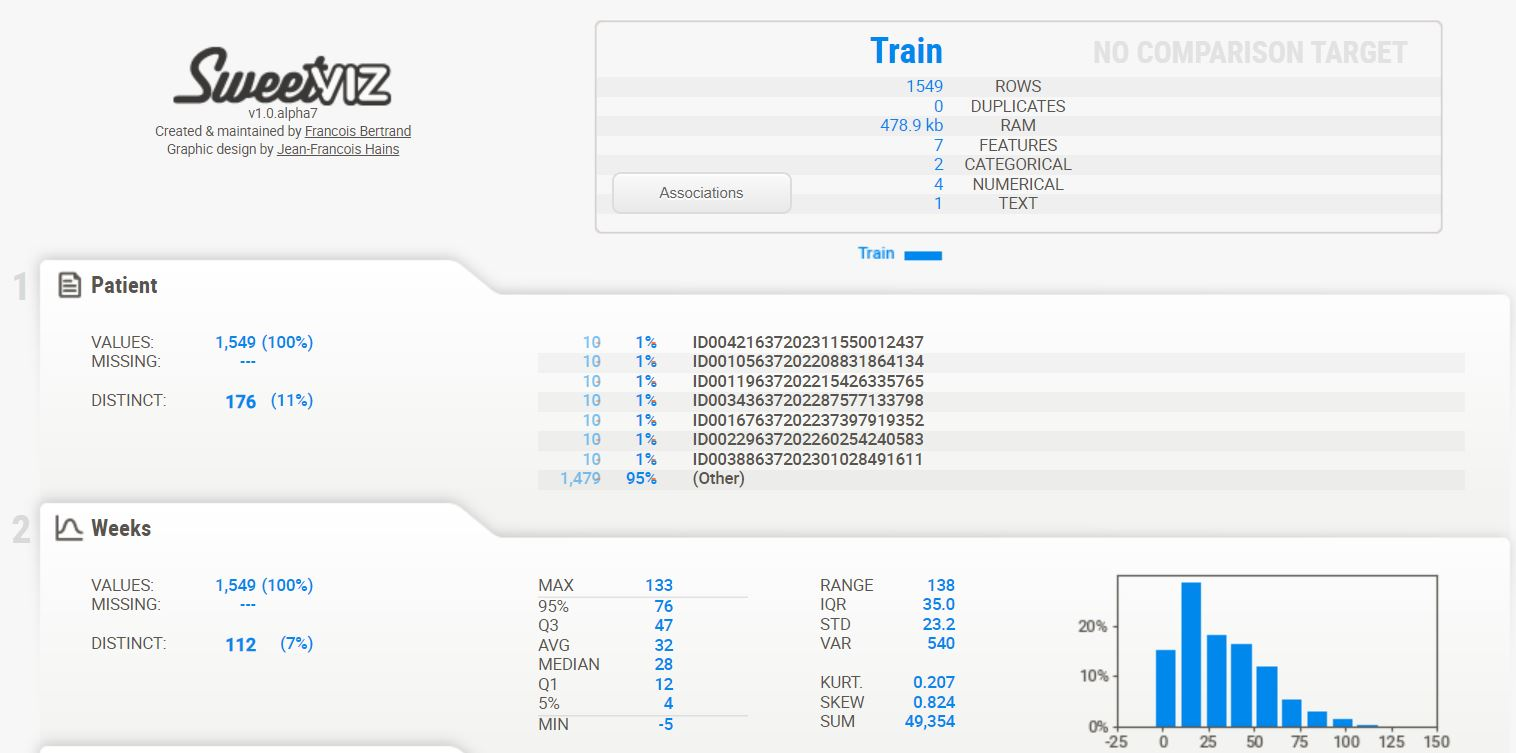

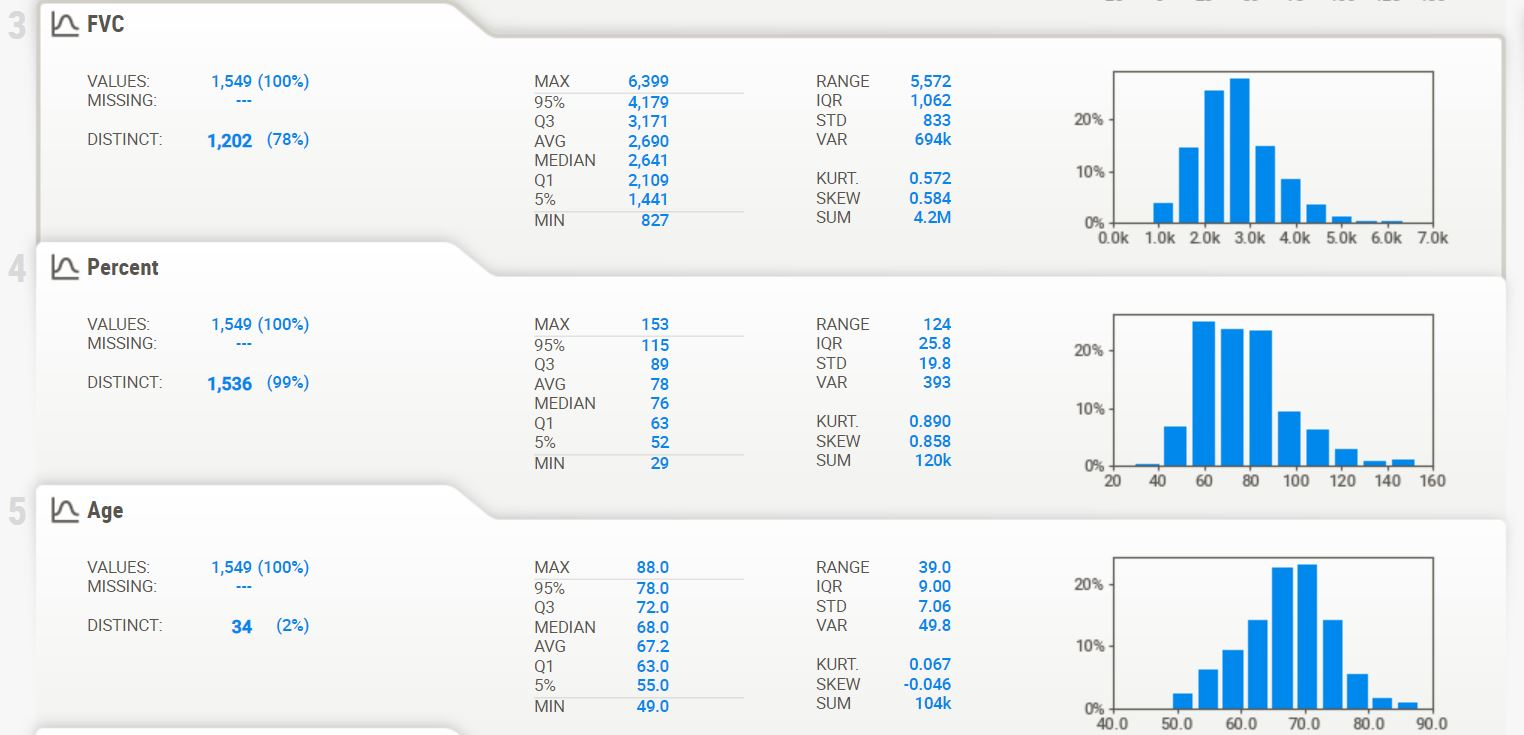

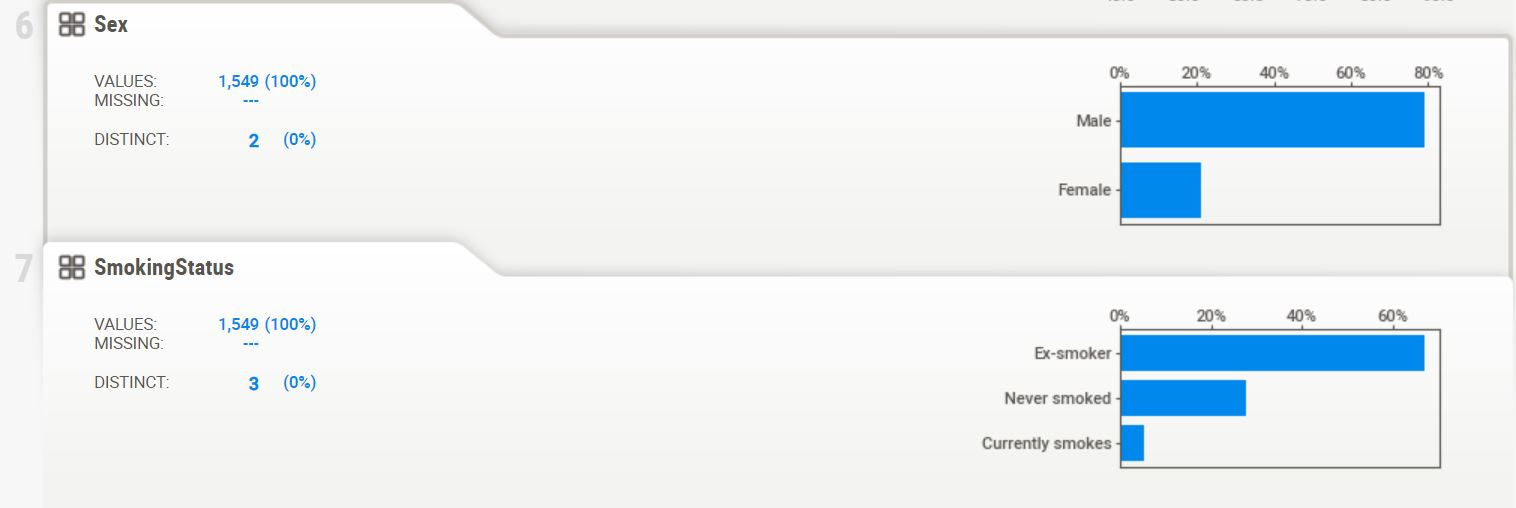

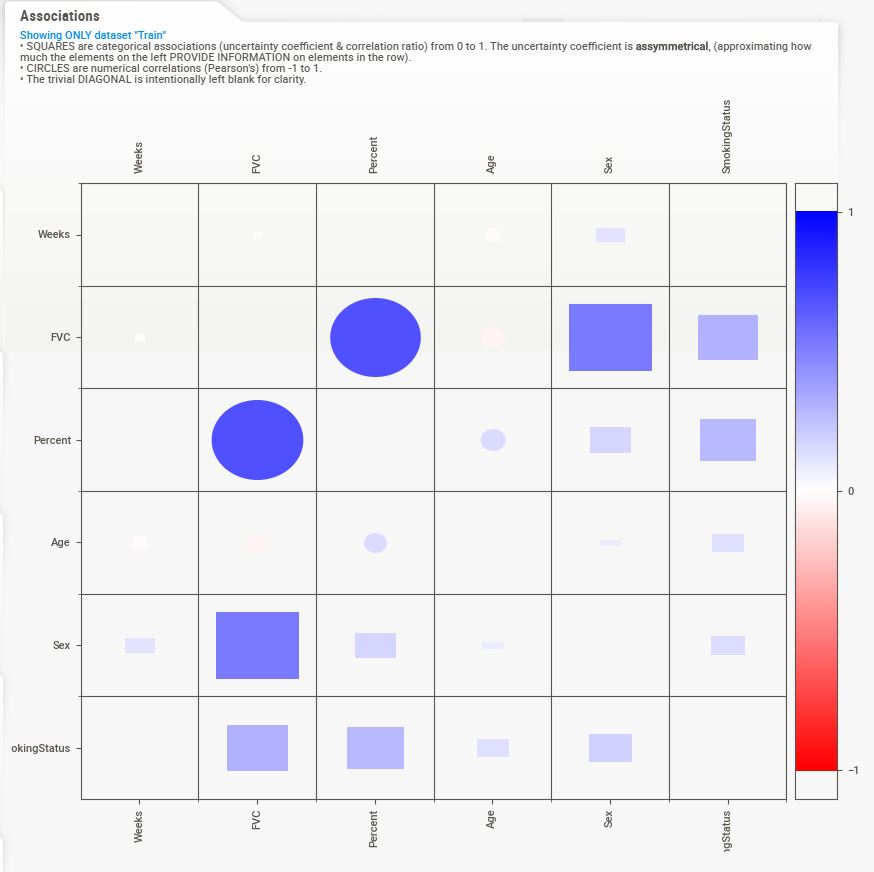

In [ ]:
#analyzing the dataset
test_df_report = sv.analyze([test_df, "Test"])

#display the report
test_df_report.show_html('test_df_report.html')


## 8.Pandas Profiling - Visualization

In [ ]:
import pandas_profiling as pdp

profile_train_df = pdp.ProfileReport(train_df)

profile_train_df

In [ ]:
profile_test_df = pdp.ProfileReport(test_df)
profile_test_df

In [ ]:
#credits:
# https://www.kaggle.com/schlerp/getting-to-know-dicom-and-the-data
# https://www.kaggle.com/parulpandey/melanoma-classification-eda-starter

## TO BE CONTINUED ....................